In [1]:


import matplotlib.pyplot as plt
from astropy.io import fits
from skimage import filters
import numpy as np

from nbd.data.editor import ReadSimulationEditor

/Users/christophschirninger/PycharmProjects/NeuralBD/venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Functions

In [2]:
def getShift(image, image_ref):
    """
    Get the shift between two images.

    Args:
        image: Image 1
        image_ref: Image 2
    """
    shifts = []
    for i in range(128):
        for j in range(128):
            shifts += [(i, j, correlation_coefficient(image_ref, image))]
    shifts = np.array(shifts)
    best_shift = shifts[np.argmax(shifts[:, 2])]
    center = (image_ref.shape[0] // 2 - image.shape[0] // 2, image_ref.shape[1] // 2 - image.shape[1] // 2)
    return (center[0] - best_shift[0], center[1] - best_shift[1])

In [3]:
def correlation_coefficient(patch1, patch2):
    """
    Pearson correlation coefficient between two patches.

    Args:
        patch1: Patch of image 1
        patch2: Patch of image 2
    """
    product = np.nanmean((patch1 - np.nanmean(patch1)) * (patch2 - np.nanmean(patch2)))
    stds = np.nanstd(patch1) * np.nanstd(patch2)
    if stds == 0:
        return 0
    else:
        product /= stds
        return product

In [4]:
from scipy.ndimage import shift


def optimize_shift(img1, img2, max_shift=20):
    """Finds the best shift that maximizes the Pearson correlation coefficient."""
    best_shift = (0, 0)
    best_corr = 0.97
    for dx in range(-max_shift, max_shift + 1):
        for dy in range(-max_shift, max_shift + 1):
            shifted_img2 = shift(img2, shift=(dx, dy), mode='nearest')
            corr = correlation_coefficient(img1, shifted_img2)
            if corr > best_corr or best_corr is None:
                best_corr = corr
                best_shift = (dx, dy)
    return best_shift, best_corr

In [5]:
def hpf(image, n=3):
    """
    High-pass filter an image using a Gaussian kernel.

    Args:
        image: Input image
        sigma: Standard deviation of the Gaussian kernel

    Returns:
        high_pass: High-pass filtered image
    """
    filter = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            filter[i, j] = np.exp(-((i - n // 2) ** 2 + (j - n // 2) ** 2) / 2)
    filter /= filter.sum()

    # Smooth the image
    smoothed = np.zeros_like(image)
    for i in range(image.shape[0] - n + 1):
        for j in range(image.shape[1] - n + 1):
            smoothed[i, j] = np.sum(image[i: i + n, j: j + n] * filter)
    return smoothed, filter

In [3]:
def compute_rms_contrast(image):
    mean = np.mean(image)
    rms = np.sqrt(np.mean((image - mean) ** 2))
    return rms

In [7]:
def contrast(image):
    min = np.min(image)
    max = np.max(image)
    return (max - min) / (max + min)

In [19]:
import numpy as np
def compute_psnr(img1, img2, max_value=255):
    """"Calculating peak signal-to-noise ratio (PSNR) between two images."""
    mse = np.mean((np.array(img1, dtype=np.float32) - np.array(img2, dtype=np.float32)) ** 2)
    if mse == 0:
        return 100
    return 20 * np.log10(max_value / (np.sqrt(mse)))

In [8]:
def get_filtered(image, cutoffs, squared_butterworth=True, order=3.0, npad=0):
    """Lowpass and highpass butterworth filtering at all specified cutoffs.

    Parameters
    ----------
    image : ndarray
        The image to be filtered.
    cutoffs : sequence of int
        Both lowpass and highpass filtering will be performed for each cutoff
        frequency in `cutoffs`.
    squared_butterworth : bool, optional
        Whether the traditional Butterworth filter or its square is used.
    order : float, optional
        The order of the Butterworth filter

    Returns
    -------
    lowpass_filtered : list of ndarray
        List of images lowpass filtered at the frequencies in `cutoffs`.
    highpass_filtered : list of ndarray
        List of images highpass filtered at the frequencies in `cutoffs`.
    """

    lowpass_filtered = []
    for cutoff in cutoffs:
        lowpass_filtered.append(
            filters.butterworth(
                image,
                cutoff_frequency_ratio=cutoff,
                order=order,
                high_pass=False,
                squared_butterworth=squared_butterworth,
                npad=npad,
            )
        )
    return lowpass_filtered

In [ ]:

from scipy.ndimage import median_filter
from scipy.signal import convolve2d


def compute_gradient(img):
    """Compute gradient magnitude using Sobel operator."""
    # Sobel filters
    sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
    sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

    # Apply Sobel filters using convolve2d (same padding for equal size output)
    grad_x = convolve2d(img, sobel_x, mode='same', boundary='symm')
    grad_y = convolve2d(img, sobel_y, mode='same', boundary='symm')

    # Compute gradient magnitude
    gradient_magnitude = np.sqrt(grad_x ** 2 + grad_y ** 2)
    return gradient_magnitude


def gradient_similarity(grad1, grad2):
    """Compute gradient similarity map."""
    eps = 1e-8  # Small constant to avoid division by zero
    return (2 * grad1 * grad2 + eps) / (grad1 ** 2 + grad2 ** 2 + eps)


def median_filter_gradient_similarity(img1, img2, kernel_size=3):
    """
    Compute the Median Filter Gradient Similarity (MFGS) between two images.

    Parameters:
        img1: First image (grayscale NumPy array).
        img2: Second image (grayscale NumPy array).
        kernel_size: Kernel size for median filtering.

    Returns:
        MFGS score (higher means more similar).
    """
    # Apply median filter
    img1_filtered = median_filter(img1, size=kernel_size)
    img2_filtered = median_filter(img2, size=kernel_size)

    # Compute gradient magnitudes
    grad1 = compute_gradient(img1_filtered)
    grad2 = compute_gradient(img2_filtered)

    # Compute gradient similarity map
    similarity_map = gradient_similarity(grad1, grad2)

    # Compute final MFGS score (mean similarity)
    return np.mean(similarity_map)

# Example Usage:
# img1 and img2 should be grayscale NumPy arrays (shape: H x W)
# score = median_filter_gradient_similarity(img1, img2)


In [1]:
import numpy as np


def shift_image_numpy(image: np.ndarray, shift_x: int, shift_y: int) -> np.ndarray:
    """
    Shifts an image by shift_x pixels in the x-direction and shift_y pixels in the y-direction
    using NumPy only, with zero-padding instead of wrapping.

    Parameters:
    - image (np.ndarray): Input grayscale image as a 2D NumPy array.
    - shift_x (int): Number of pixels to shift along the x-axis (right if positive, left if negative).
    - shift_y (int): Number of pixels to shift along the y-axis (down if positive, up if negative).

    Returns:
    - np.ndarray: Shifted image with zero-padding.
    """
    # Create an empty array with the same shape, filled with zeros
    shifted_image = np.zeros_like(image)

    # Image dimensions
    h, w = image.shape

    # Determine valid regions to copy from and paste into
    y_start, y_end = max(0, shift_y), min(h, h + shift_y)
    x_start, x_end = max(0, shift_x), min(w, w + shift_x)

    src_y_start, src_y_end = max(0, -shift_y), min(h, h - shift_y)
    src_x_start, src_x_end = max(0, -shift_x), min(w, w - shift_x)

    # Copy the valid region from the original image to the shifted image
    shifted_image[y_start:y_end, x_start:x_end] = image[src_y_start:src_y_end, src_x_start:src_x_end]

    return shifted_image

# Load data

In [3]:
fits_array = []
data_path = '/Users/christophschirninger/PhD/NeuralBD/data/hifi_20220602_095015_sd.fts'
for i in range(1, 201):  # <-- 2022: 0, 200 ; 2022-->: 1,201
    fits_array.append(fits.getdata(data_path, i))
h, w = fits_array[0].shape
fits_array = np.stack(fits_array, -1).reshape((h, w, 100, 2))
#fits_array = fits_array[:, :, :, 0]
#fits_array = fits_array[800:1312, 800:1312, :]

In [6]:
fits_array, fits_header = [], []
data_path = '/Users/christophschirninger/PhD/NeuralBD/data/hifi_20220602_095015_sd.fts'
for i in range(1, 201):
    fits_array.append(fits.getdata(data_path, i))
    fits_header.append(fits.getheader(data_path, i))
h, w = fits_array[0].shape
fits_array = np.stack(fits_array, -1).reshape((h, w, 100, 2))

# Image quality estimation

In [7]:
mfgs = [fits_header[i]['MFGSMEAN'] for i in np.arange(1, 201, 2)]

In [8]:
np.mean(mfgs), np.std(mfgs)

(0.88069075, 0.005582553051024233)

In [9]:
highest_indices = [index for index, value in
                   sorted(enumerate(mfgs), key=lambda x: x[1], reverse=True)[:50]]

In [10]:
highest_indices

[31,
 80,
 34,
 63,
 93,
 40,
 38,
 88,
 78,
 27,
 59,
 15,
 32,
 62,
 76,
 65,
 81,
 66,
 68,
 8,
 44,
 17,
 13,
 33,
 10,
 67,
 39,
 58,
 72,
 1,
 95,
 82,
 30,
 46,
 25,
 87,
 57,
 61,
 51,
 35,
 56,
 22,
 79,
 52,
 5,
 60,
 14,
 69,
 18,
 49]

In [11]:
fits_array_mfgs = np.stack([fits_array[:, :, i, :] for i in highest_indices], -2)

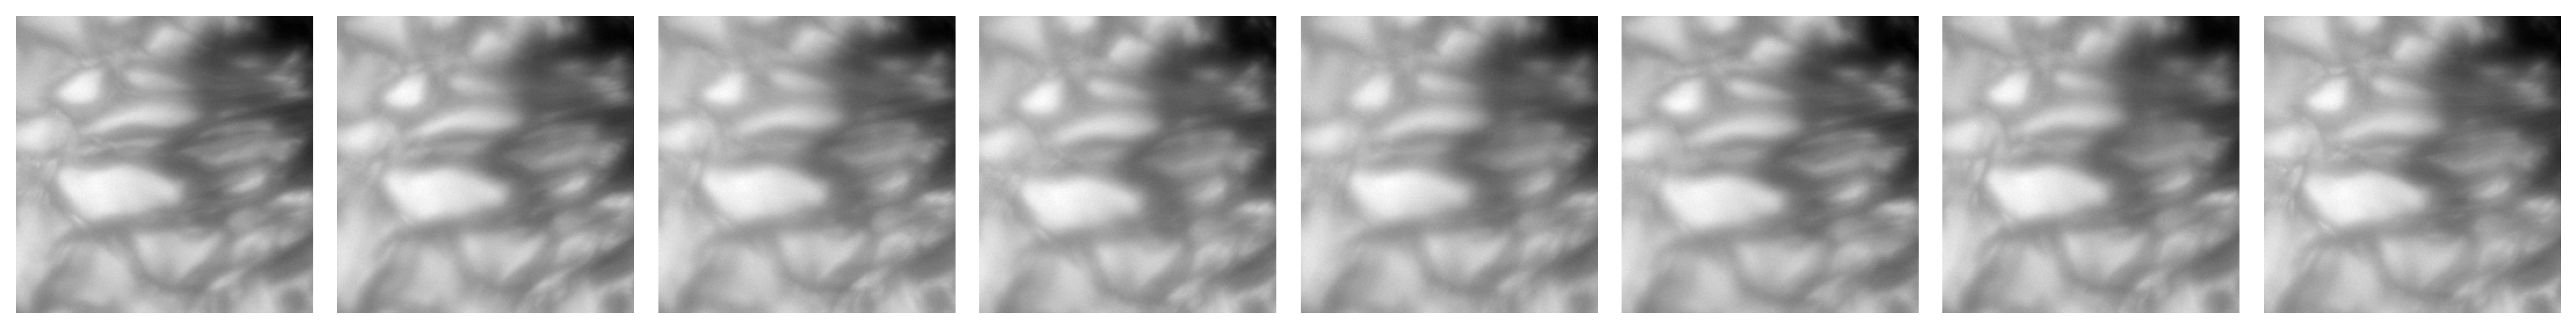

In [31]:
fig, axs = plt.subplots(1, 8, figsize=(16, 4), dpi=300)
for i in range(8):
    ax = axs[i]
    ax.imshow(fits_array_mfgs[900:1156, 900:1156, i, 0], cmap='gray', origin='lower')
    ax.set_axis_off()
fig.tight_layout()
plt.show()

[35.505907365389675,
 33.118281744262134,
 38.11243545473437,
 36.40741397204212,
 32.378609701542445,
 39.293343942483915,
 31.568655509024637,
 32.33607074498579,
 33.73639598443455,
 32.493736915964035,
 33.27965528386696,
 33.248464779847126,
 32.47337500425394,
 31.057021980959433,
 27.497326813175476,
 29.458705312212004,
 31.06804907167222,
 34.39464249081695,
 33.853291070401355,
 31.053081604660036,
 35.30659526876909,
 38.31387113802222,
 35.0475960815572,
 33.74772992001974,
 33.76462197156863,
 34.074113039729326,
 35.937003167966594,
 33.21777771073059,
 32.487044832186456,
 31.59984871611195,
 35.6630710284206,
 32.61825641996231,
 34.13828276289743,
 34.45664289960311,
 36.17766362778886,
 34.275044662356066,
 35.00768880612654,
 34.10001455516314,
 35.113160210793666,
 36.193941024841905,
 38.328037908797995,
 31.639086362101892,
 29.477201495966,
 29.656574190778628,
 35.04139442690732,
 28.764171595589318,
 36.81034209857259,
 35.57496388565207,
 34.214560261028254,
 

In [41]:
vmin, vmax = fits_array.min(), fits_array.max()
fits_array = (fits_array - vmin) / (vmax - vmin)
fits_array.min(), fits_array.max()

(0.0, 1.0)

In [43]:
# Brisque
from brisque import BRISQUE
import cv2

fits_array_crop = fits_array[900:1028, 900:1028, :, 0]
vmin, vmax = fits_array_crop.min(), fits_array_crop.max()
fits_array_crop = (fits_array_crop - vmin) / (vmax - vmin)

brisque = BRISQUE(url=False)
brisque_score = [brisque.score(cv2.cvtColor(fits_array_crop[:, :, i], cv2.COLOR_GRAY2BGR)) for i in range(100)]

In [44]:
lowest_indices = [index for index, value in
                   sorted(enumerate(brisque_score), key=lambda x: x[1])[:50]]

In [45]:
lowest_indices

[14,
 59,
 82,
 45,
 42,
 15,
 52,
 13,
 41,
 16,
 51,
 99,
 64,
 29,
 27,
 43,
 10,
 31,
 19,
 76,
 79,
 49,
 7,
 80,
 9,
 71,
 58,
 11,
 12,
 98,
 1,
 28,
 4,
 75,
 6,
 92,
 23,
 17,
 85,
 60,
 35,
 78,
 24,
 83,
 77,
 32,
 37,
 74,
 86,
 18]

In [46]:
fits_array_stack_brisque = np.stack([fits_array[:, :, i, :] for i in lowest_indices], -2)

In [9]:
contrast = [compute_rms_contrast(fits_array[900:1028, :, i]) for i in range(fits_array.shape[-2])]

In [10]:
contrast

[0.14237377,
 0.14895485,
 0.14683154,
 0.14384663,
 0.1472631,
 0.14439073,
 0.1450467,
 0.14446817,
 0.1455593,
 0.14724801,
 0.14836387,
 0.14739828,
 0.14366585,
 0.14626297,
 0.14560716,
 0.14608835,
 0.14292434,
 0.14801565,
 0.14725867,
 0.14576435,
 0.14712791,
 0.14836766,
 0.14524025,
 0.14699863,
 0.14762759,
 0.14378898,
 0.14759919,
 0.14887871,
 0.14547822,
 0.14490996,
 0.14936961,
 0.14951283,
 0.14972064,
 0.14627673,
 0.14713354,
 0.14840803,
 0.14519055,
 0.14597724,
 0.14845565,
 0.14944297,
 0.1532217,
 0.15044054,
 0.14443316,
 0.14175996,
 0.1452852,
 0.14250925,
 0.14784719,
 0.14633976,
 0.14388412,
 0.14580762,
 0.1487698,
 0.14579543,
 0.15148401,
 0.14669564,
 0.14582083,
 0.14872666,
 0.14384747,
 0.14460611,
 0.15060599,
 0.15097398,
 0.14677224,
 0.14569569,
 0.14574765,
 0.15251908,
 0.14612228,
 0.14773968,
 0.14769152,
 0.14512055,
 0.14576659,
 0.14723781,
 0.14700942,
 0.14582124,
 0.15039004,
 0.13973403,
 0.15220515,
 0.14695296,
 0.15232821,
 0.14

In [11]:
highest_indices = [index for index, value in
                   sorted(enumerate(contrast), key=lambda x: x[1], reverse=True)[:50]]

In [12]:
highest_indices

[40,
 63,
 76,
 74,
 86,
 83,
 52,
 88,
 59,
 95,
 58,
 97,
 41,
 72,
 89,
 32,
 94,
 80,
 31,
 39,
 30,
 91,
 1,
 27,
 50,
 55,
 78,
 93,
 38,
 35,
 21,
 10,
 82,
 17,
 46,
 65,
 66,
 24,
 26,
 11,
 77,
 4,
 18,
 9,
 69,
 34,
 20,
 92,
 70,
 23]

In [13]:
fits_array_stack = np.stack([fits_array[:, :, i, :] for i in highest_indices], -2)

In [27]:
fits_array_stack.shape

(2160, 2560, 50, 2)

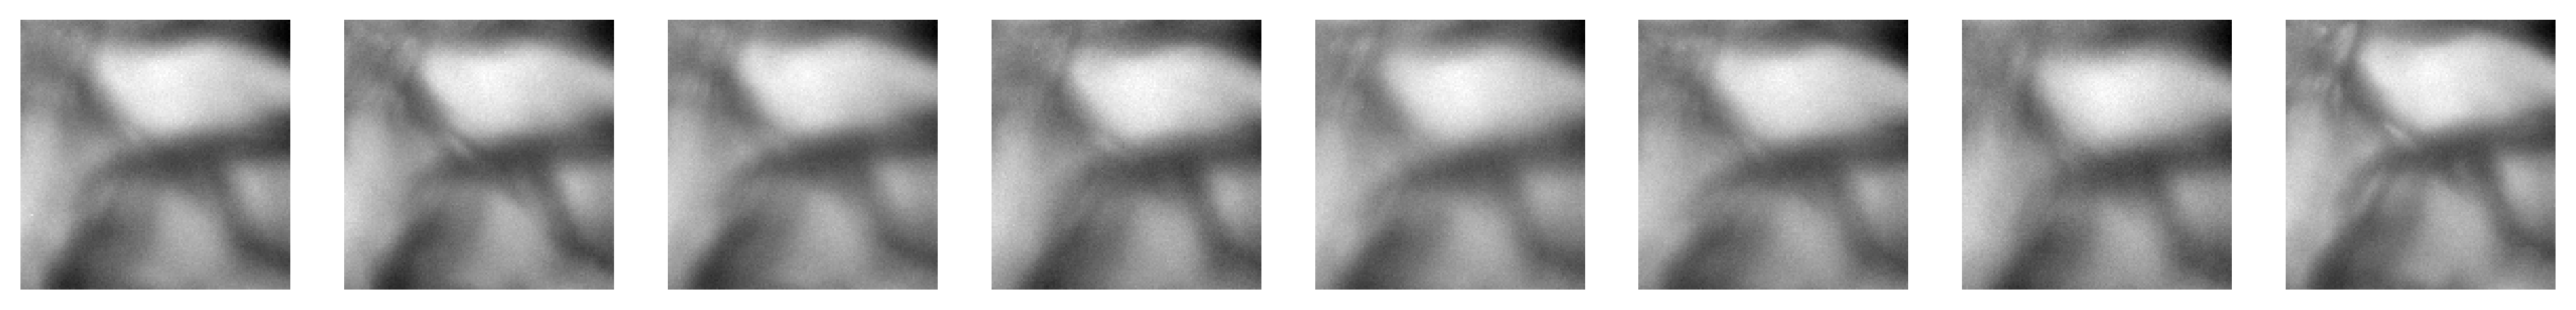

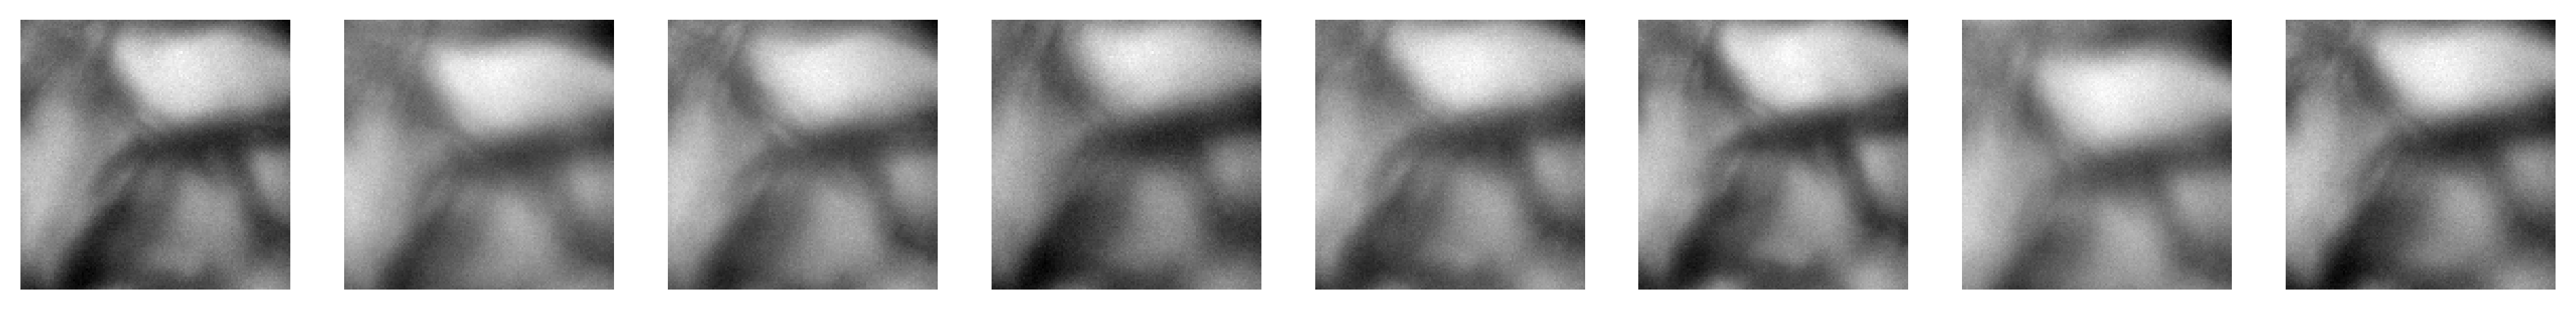

In [47]:
fig, axs = plt.subplots(1, 8, figsize=(16, 4), dpi=300)
for i in range(8):
    ax = axs[i]
    ax.imshow(fits_array_stack[900:1028, 900:1028, i, 0], cmap='gray', origin='lower')
    ax.set_axis_off()
plt.show()
fig, axs = plt.subplots(1, 8, figsize=(16, 4), dpi=300)
for i in range(8):
    ax = axs[i]
    ax.imshow(fits_array_stack_brisque[900:1028, 900:1028, i, 0], cmap='gray', origin='lower')
    ax.set_axis_off()
plt.show()

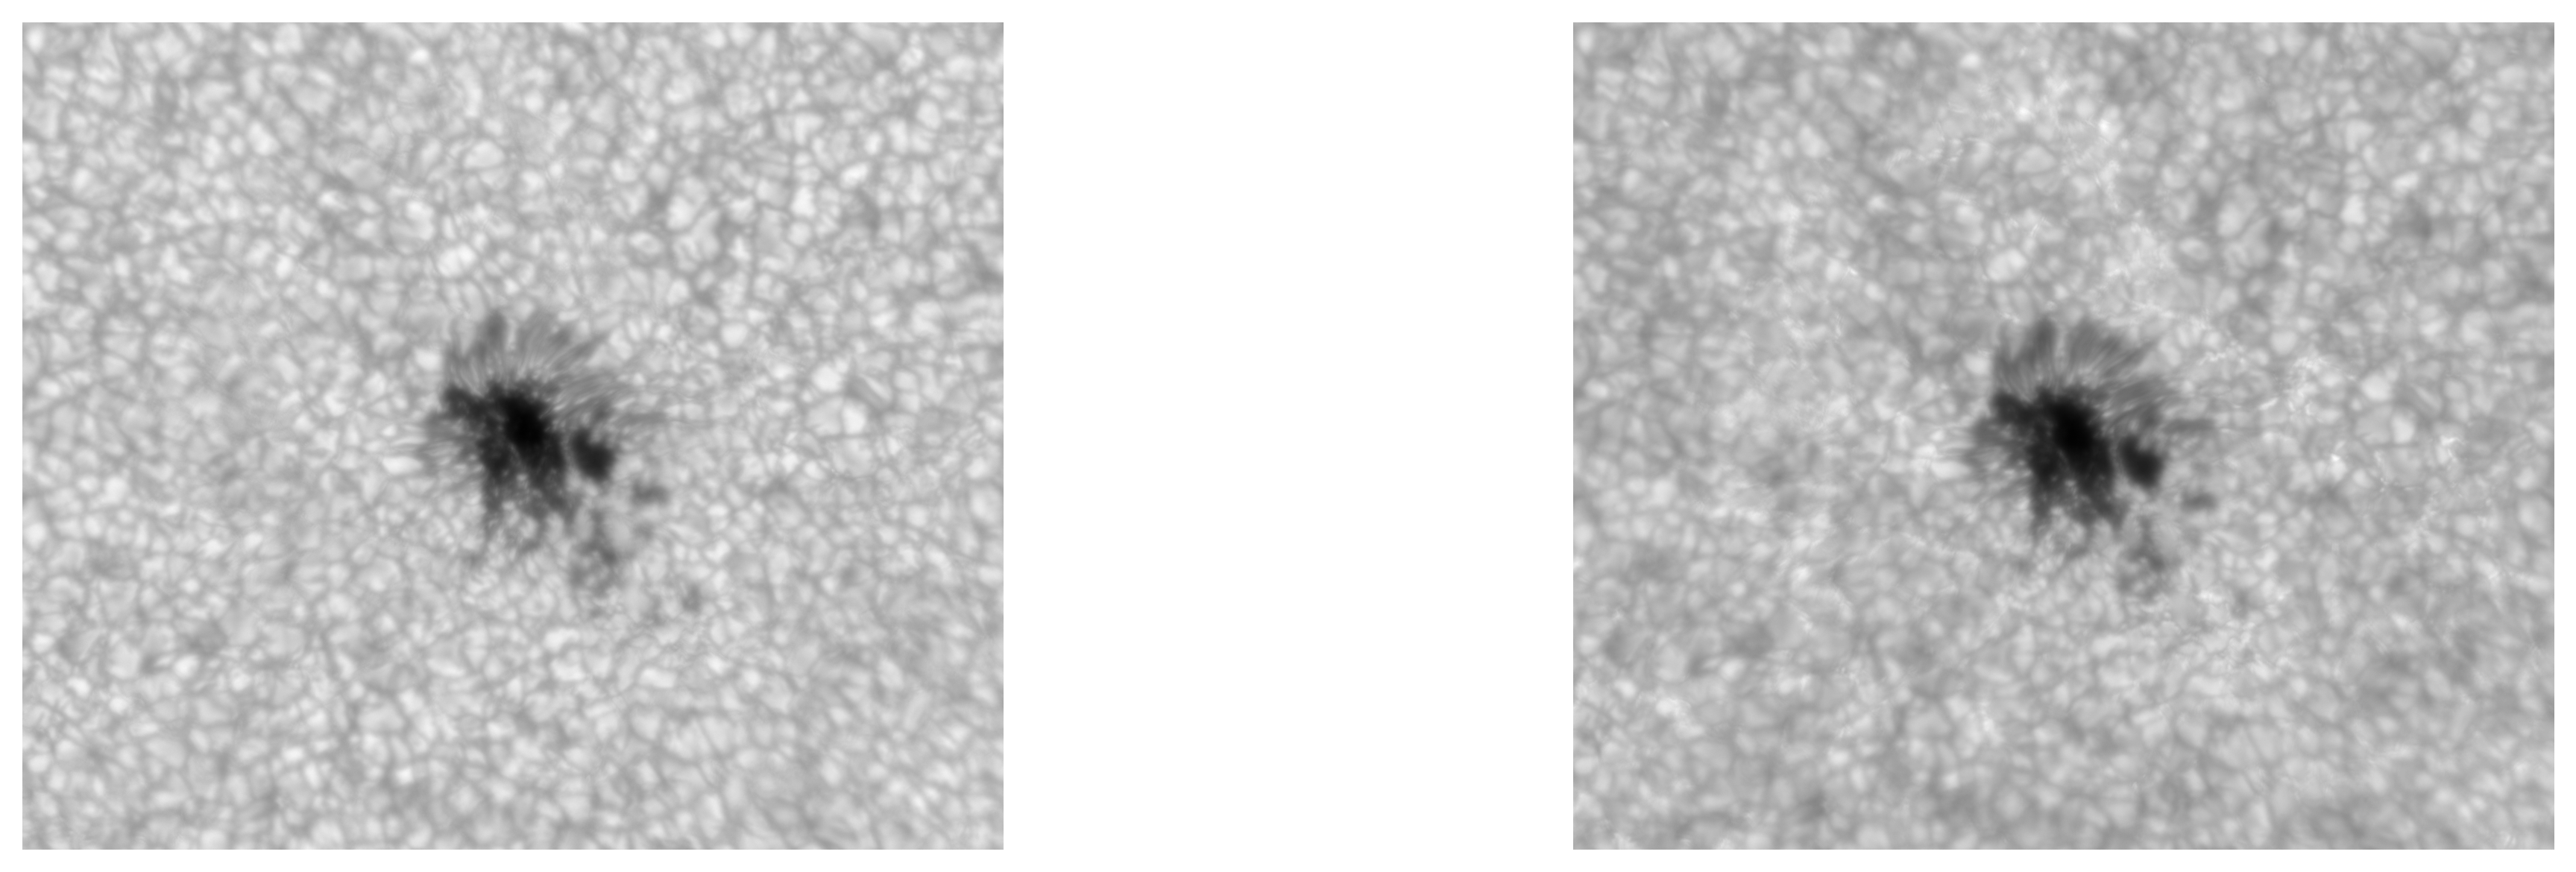

In [7]:
fig, axs = plt.subplots(1, 2, figsize=(16, 4), dpi=300)
axs[0].imshow(fits_array[:, :, 0, 0], cmap='gray', origin='lower')
axs[1].imshow(fits_array[:, :, 0, 1], cmap='gray', origin='lower')
axs[0].axis('off')
axs[1].axis('off')
plt.tight_layout()
plt.show()

# Simulation data

In [62]:
from nbd.data.editor import get_KL_basis, get_KL_wavefront, generate_PSFs, ReadSimulationEditor, get_convolution, \
    cutout, get_filtered, optimize_shift, shift_image, compute_rms_contrast

muram = ReadSimulationEditor().call('/Users/christophschirninger/PhD/NeuralBD/data/I_out_med.468000')
sim_array = muram.data
vmin, vmax = 0, np.percentile(sim_array, 99)
muram = (sim_array - vmin) / (vmax - vmin)
muram = np.stack([muram, muram], -1)
#muram = muram[500:756, 500:756]

In [63]:
kl_basis = get_KL_basis(n_modes_max=44, size=29)
kl_wavefront = get_KL_wavefront(kl_basis, 44, 50, coef_range=2)
psfs = generate_PSFs(kl_wavefront, 50)

Computing Kolmogorov covariance...
Diagonalizing Kolmogorov covariance...
Computing KL modes...


100%|██████████| 46/46 [00:00<00:00, 811.10it/s]


In [64]:
high_quality = cutout(muram, 332, 332, 64)

In [65]:
images = get_convolution(high_quality, psfs, 50, noise=False)
images_noise = get_convolution(high_quality, psfs, 50, noise=True)

In [71]:
vmin_imgs, vmax_imgs = images.min(), images.max()
images = (images - vmin_imgs) / (vmax_imgs - vmin_imgs)

vmin_imgs_noise, vmax_imgs_noise = images_noise.min(), images_noise.max()
images_noise = (images_noise - vmin_imgs_noise) / (vmax_imgs_noise - vmin_imgs_noise)

In [72]:
images_noise.min(), images_noise.max()

(0.0, 1.0)

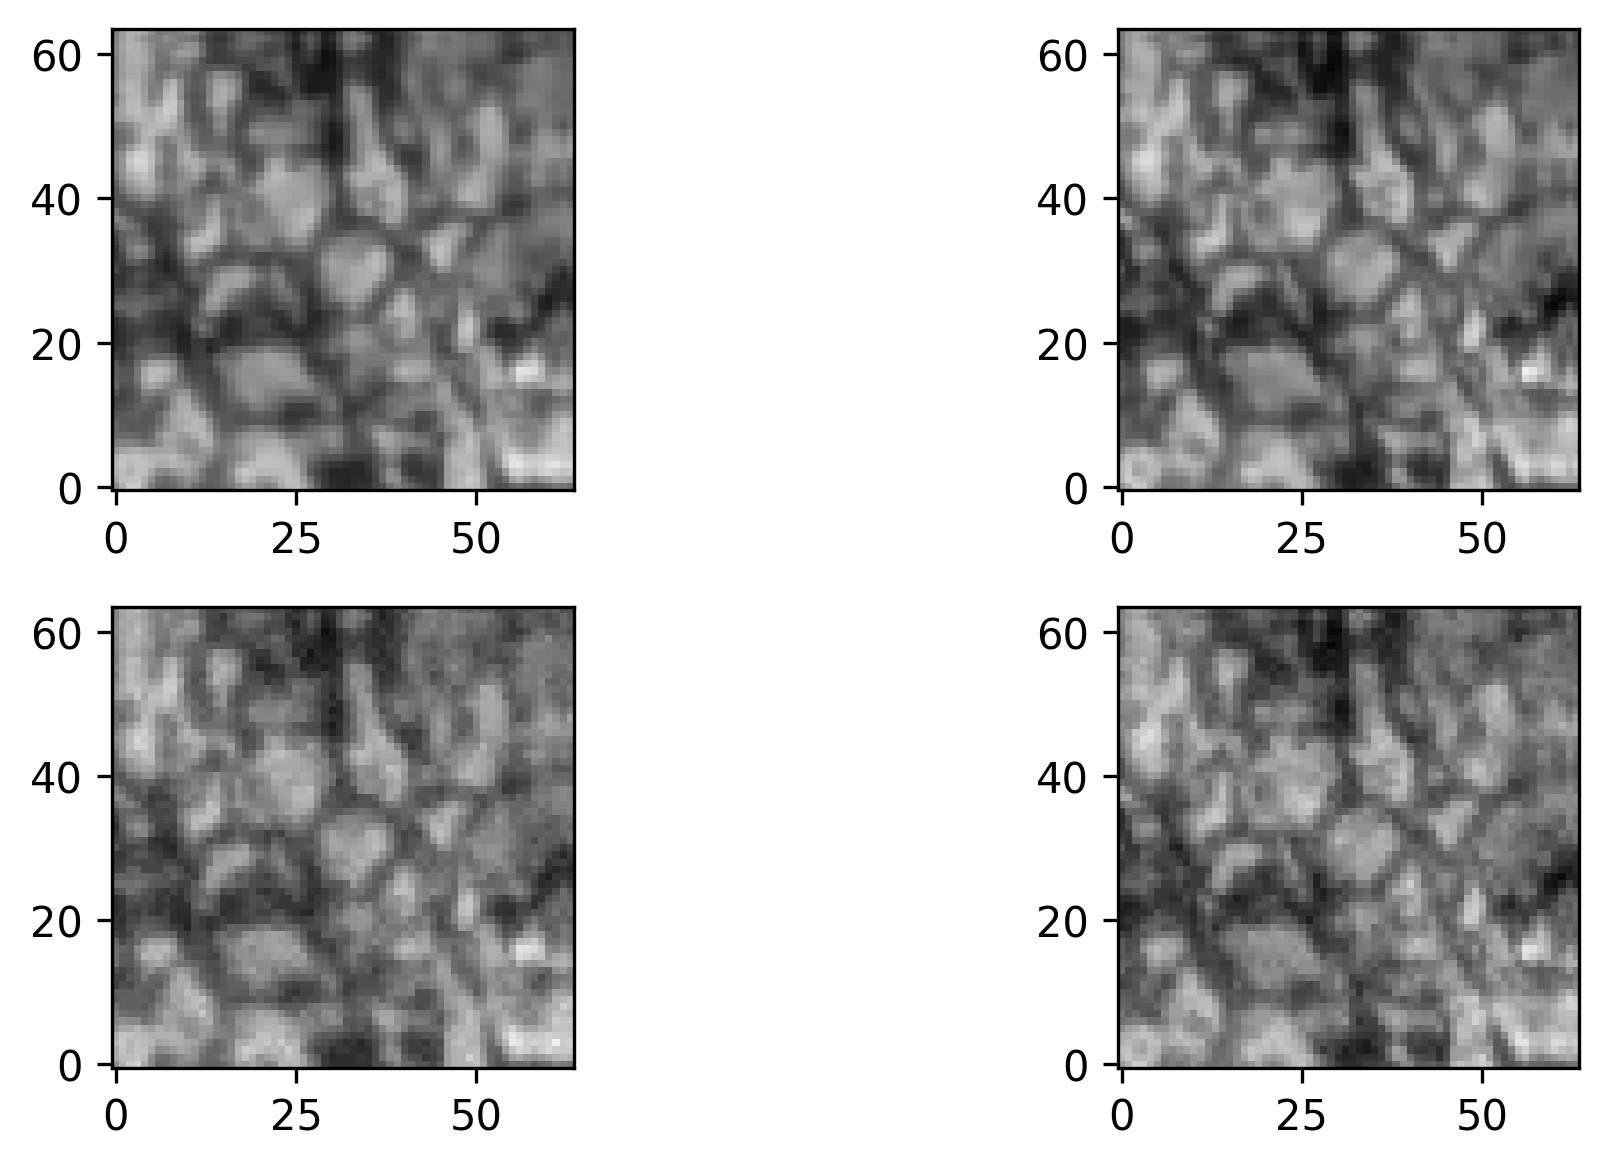

In [74]:
fig, axs = plt.subplots(2, 2, figsize=(8, 4), dpi=300)
axs[0, 0].imshow(images[:, :, 0, 0], cmap='gray', origin='lower', vmin=0, vmax=1)
axs[0, 1].imshow(images[:, :, 1, 0], cmap='gray', origin='lower', vmin=0, vmax=1)
axs[1, 0].imshow(images_noise[:, :, 0, 0], cmap='gray', origin='lower', vmin=0, vmax=1)
axs[1, 1].imshow(images_noise[:, :, 1, 0], cmap='gray', origin='lower', vmin=0, vmax=1)
plt.tight_layout()
plt.show()

In [60]:
muram_gaus = muram + gaussian
fig, axs = plt.subplots(1, 3, figsize=(40, 20))
axs[0].imshow(muram[500:756, 500:756], cmap='gray', origin='lower')
axs[1].imshow(muram_gaus[500:756, 500:756], cmap='gray', origin='lower')
axs[2].imshow(gaussian[500:756, 500:756])
plt.tight_layout()
plt.show()
plt.close()

NameError: name 'gaussian' is not defined

In [11]:
#rms = [rms_contrast(fits_array[900:1028, 900:1028, i]) for i in range(100)]
cont = [contrast(fits_array[900:1028, 900:1028, i]) for i in range(100)]

[0, 51, 93, 8, 66, 15, 54, 64, 92, 35]

In [7]:
print(cont)

[0.18715696, 0.21376689, 0.1962475, 0.17943926, 0.20949219, 0.17422044, 0.18795544, 0.18405855, 0.21121694, 0.20159546, 0.22799234, 0.19592498, 0.19699346, 0.17994629, 0.18188922, 0.1963983, 0.18316975, 0.20775491, 0.19928452, 0.19355237, 0.2059262, 0.20904993, 0.18281543, 0.200804, 0.20852415, 0.183717, 0.20832607, 0.21102448, 0.18445024, 0.19375578, 0.21510923, 0.22292145, 0.2242407, 0.21822636, 0.20837617, 0.20519577, 0.18996276, 0.19109315, 0.21265462, 0.21415906, 0.22827892, 0.2077341, 0.18830304, 0.17325416, 0.18152177, 0.17409427, 0.20393468, 0.19493136, 0.17039043, 0.20229514, 0.20848908, 0.17638645, 0.21017286, 0.20394205, 0.19657911, 0.21380922, 0.1757985, 0.1731204, 0.20942461, 0.21126202, 0.19530013, 0.19995114, 0.18978351, 0.23442599, 0.19569068, 0.20257817, 0.21381228, 0.18343055, 0.19770767, 0.20230125, 0.20272493, 0.1956592, 0.2211527, 0.16293846, 0.210797, 0.21329816, 0.23586413, 0.20019042, 0.21638125, 0.18918037, 0.22222796, 0.206075, 0.19999926, 0.22745258, 0.194335

In [18]:
lowest_indices = [index for index, value in sorted(enumerate(rms), key=lambda x: x[1])[:80]]
print(lowest_indices)

[29, 16, 0, 73, 2, 6, 99, 79, 48, 43, 18, 98, 45, 47, 23, 19, 94, 49, 71, 4, 77, 26, 82, 12, 21, 42, 92, 22, 37, 25, 75, 90, 24, 36, 60, 28, 11, 7, 20, 97, 68, 9, 55, 14, 35, 3, 33, 61, 58, 41, 91, 52, 89, 54, 53, 96, 30, 13, 84, 50, 17, 69, 5, 70, 59, 74, 56, 85, 95, 64, 57, 78, 8, 51, 1, 66, 86, 10, 62, 67]


In [12]:
highest_indices = [index for index, value in sorted(enumerate(cont), key=lambda x: x[1], reverse=True)[:80]]
print(highest_indices)

[88, 76, 63, 86, 40, 10, 83, 32, 31, 80, 72, 89, 95, 33, 78, 30, 39, 66, 55, 1, 75, 38, 59, 8, 27, 91, 74, 52, 4, 58, 94, 21, 85, 24, 50, 34, 26, 17, 41, 81, 20, 35, 99, 53, 46, 70, 97, 65, 69, 49, 9, 23, 77, 82, 61, 18, 68, 12, 54, 15, 2, 92, 11, 64, 71, 60, 93, 47, 84, 29, 19, 96, 37, 36, 62, 79, 42, 98, 6, 87]


In [13]:
#fits_array_rms = np.stack([fits_array[:, :, i] for i in lowest_indices], -1)
fits_array_cont = np.stack([fits_array[:, :, i] for i in highest_indices], -1)

In [15]:
vmin, vmax = np.min(fits_array_cont), np.max(fits_array_cont)
fits_array_cont.shape[-1]

80

In [16]:
vmin_ind = [np.min(fits_array_cont[:, :, i]) for i in range(fits_array_cont.shape[-1])]
vmax_ind = [np.max(fits_array_cont[:, :, i]) for i in range(fits_array_cont.shape[-1])]

In [19]:
fits_array_cont_norm = (fits_array_cont - vmin) / (vmax - vmin)
fits_array_cont_norm_ind = [(fits_array_cont[:, :, i] - vmin_ind[i]) / (vmax_ind[i] - vmin_ind[i]) for i in
                            range(fits_array_cont.shape[-1])]

In [20]:
fits_array_cont_norm_ind_stack = np.stack(fits_array_cont_norm_ind, -1)
fits_array_cont_norm_ind_stack.shape

(2160, 2560, 80)

In [25]:
index = 10
fits_array_cont_norm[:, :, index].min(), fits_array_cont_norm[:, :, index].max(), fits_array_cont_norm_ind_stack[:, :,
                                                                                  index].min(), fits_array_cont_norm_ind_stack[
                                                                                                :, :, index].max()

(0.007616757, 0.97696704, 0.0, 1.0)

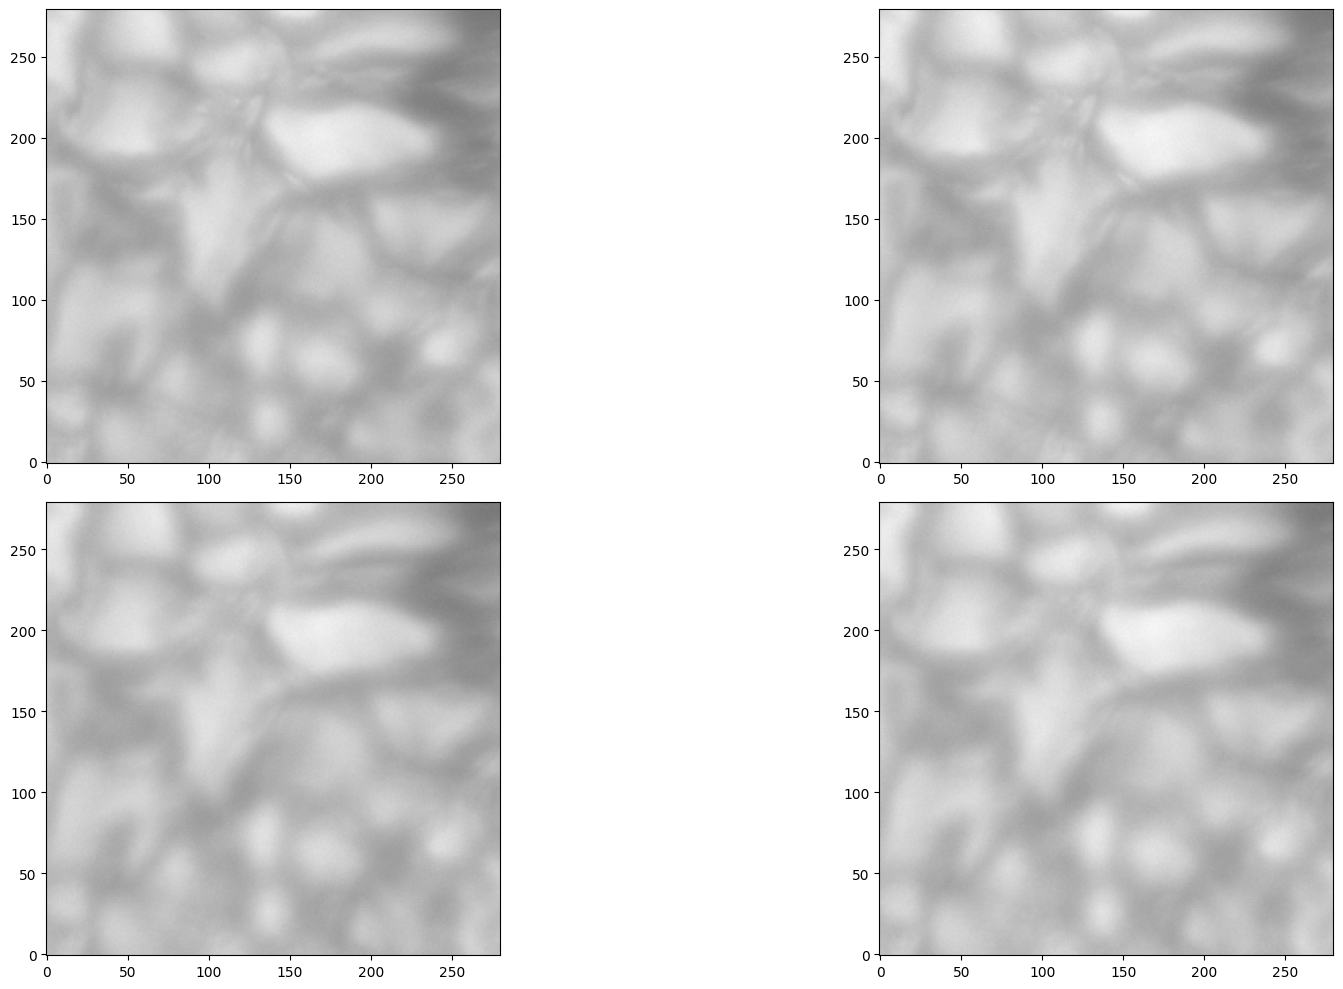

In [26]:
fig, axs = plt.subplots(2, 2, figsize=(20, 10))
axs[0, 0].imshow(fits_array_cont_norm[900:1028, 900:1028, 0], cmap='gray', vmin=0, vmax=1, origin='lower')
axs[0, 1].imshow(fits_array_cont_norm_ind_stack[900:1028, 900:1028, 0], vmin=0, vmax=1, cmap='gray', origin='lower')
axs[1, 0].imshow(fits_array_cont_norm[900:1028, 900:1028, index], cmap='gray', vmin=0, vmax=1, origin='lower')
axs[1, 1].imshow(fits_array_cont_norm_ind_stack[900:1028, 900:1028, index], cmap='gray', vmin=0, vmax=1, origin='lower')
plt.tight_layout()
plt.show()

In [29]:
for i in range(fits_array_cont.shape[-1]):
    plt.imsave('/Users/christophschirninger/PycharmProjects/NeuralBD/orig_' + str(i) + '.jpg',
               fits_array_cont_norm[800:1080, 800:1080, i], cmap='gray', origin='lower', vmin=0, vmax=1)
    plt.imsave('/Users/christophschirninger/PycharmProjects/NeuralBD/norm_' + str(i) + '.jpg',
               fits_array_cont_norm_ind_stack[800:1080, 800:1080, i], cmap='gray', origin='lower', vmin=0, vmax=1)

In [10]:
pcc = correlation_coefficient(fits_array_cont[:, :, 0], fits_array_cont[:, :, 9])
print(pcc)

0.92148125


In [11]:
pcc = correlation_coefficient(fits_array_cont[800:1080, 800:1080, 0], fits_array_cont[800:1080, 800:1080, 9])
print(pcc)

0.8781139


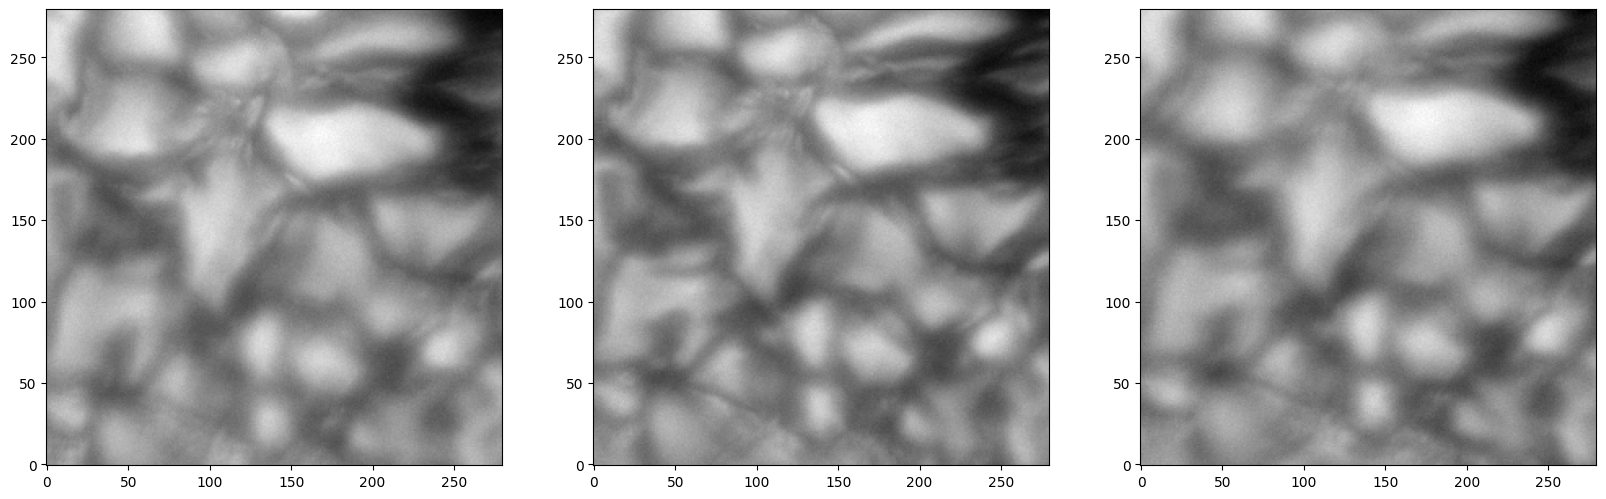

In [26]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(fits_array_cont[800:1080, 800:1080, 0], cmap='gray', origin='lower')
axs[1].imshow(fits_array_cont[800:1080, 800:1080, 8], cmap='gray', origin='lower')
axs[2].imshow(fits_array_cont[800:1080, 800:1080, -1], cmap='gray', origin='lower')
plt.show()

In [15]:
fits_array_mfgs[:, :, 0, 0].shape

(2160, 2560)

# Shift

In [34]:
from tqdm import tqdm

x_crop = 964
y_crop = 964
crop_size = 128
max_shift = 130
shifting = [optimize_shift(fits_array[x_crop - max_shift:x_crop + crop_size + max_shift,
                                              x_crop - max_shift:x_crop + crop_size + max_shift, 0, 0],
                                              fits_array[x_crop - max_shift:x_crop + crop_size + max_shift,
                                              x_crop - max_shift:x_crop + crop_size + max_shift, i, 0]) for i in range(10)]

In [51]:
shifting[3][0][1]

-2

In [52]:
def shift_image_numpy(image: np.ndarray, shift_x: int, shift_y: int) -> np.ndarray:
    """
    Shifts an image by shift_x pixels in the x-direction and shift_y pixels in the y-direction
    using NumPy only, with zero-padding instead of wrapping.

    Parameters:
    - image (np.ndarray): Input grayscale image as a 2D NumPy array.
    - shift_x (int): Number of pixels to shift along the x-axis (right if positive, left if negative).
    - shift_y (int): Number of pixels to shift along the y-axis (down if positive, up if negative).

    Returns:
    - np.ndarray: Shifted image with zero-padding.
    """
    # Create an empty array with the same shape, filled with zeros
    shifted_image = np.zeros_like(image)

    # Image dimensions
    h, w = image.shape

    # Determine valid regions to copy from and paste into
    y_start, y_end = max(0, shift_y), min(h, h + shift_y)
    x_start, x_end = max(0, shift_x), min(w, w + shift_x)

    src_y_start, src_y_end = max(0, -shift_y), min(h, h - shift_y)
    src_x_start, src_x_end = max(0, -shift_x), min(w, w - shift_x)

    # Copy the valid region from the original image to the shifted image
    shifted_image[y_start:y_end, x_start:x_end] = image[src_y_start:src_y_end, src_x_start:src_x_end]

    return shifted_image

In [62]:
shifted_img = np.stack([shift_image_numpy(fits_array[x_crop - max_shift:x_crop + crop_size + max_shift, x_crop - max_shift:x_crop + crop_size + max_shift, i, 0], shifting[i][0][1], shifting[i][0][0]) for i in range(10)], -1)

In [63]:
shifted_img.shape

(388, 388, 10)

In [64]:
def cutout(image, x, y, size):
    return image[x - size // 2:x + size // 2, y - size // 2:y + size // 2, :]

In [68]:
shift_crop = cutout(shifted_img, max_shift, max_shift, crop_size)

In [69]:
shift_crop.shape

(128, 128, 10)

In [72]:
fig, axs = plt.subplots(2, 3, figsize=(20, 10))
axs[0, 0].imshow(shift_crop[:, :, 1], cmap='gray', origin='lower')
axs[0, 1].imshow(shift_crop[:, :, 2], cmap='gray', origin='lower')
axs[0, 2].imshow(shift_crop[:, :, 3], cmap='gray', origin='lower')
axs[1, 0].imshow(fits_array[900:1028, 900:1028, 1, 0], cmap='gray', origin='lower')
axs[1, 1].imshow(fits_array[900:1028, 900:1028, 2, 0], cmap='gray', origin='lower')
axs[1, 2].imshow(fits_array[900:1028, 900:1028, 3, 0], cmap='gray', origin='lower')
plt.show()

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
axs[0].imshow(shifted_img[20:148, 20:148, 0], cmap='gray', origin='lower')
axs[1].imshow(shifted_img[20:148, 20:148, 1], cmap='gray', origin='lower')
axs[2].imshow(shifted_img[20:148, 20:148, 2], cmap='gray', origin='lower')
plt.show()

  0%|          | 0/5 [1:02:36<?, ?it/s]


In [21]:
shifted_img = np.stack(
    [shift(fits_array_mfgs[820:1228, 820:1228, i, 0], shift=shifting[i][0], mode='nearest') for i in range(50)], -1)

In [22]:
shifted_img.shape

(408, 408, 50)

In [35]:
for i in range(10):
    plt.imsave('/Users/christophschirninger/PycharmProjects/NeuralBD/' + str(i) + '.jpg', shifted_img[:, :, i],
               cmap='gray', origin='lower')

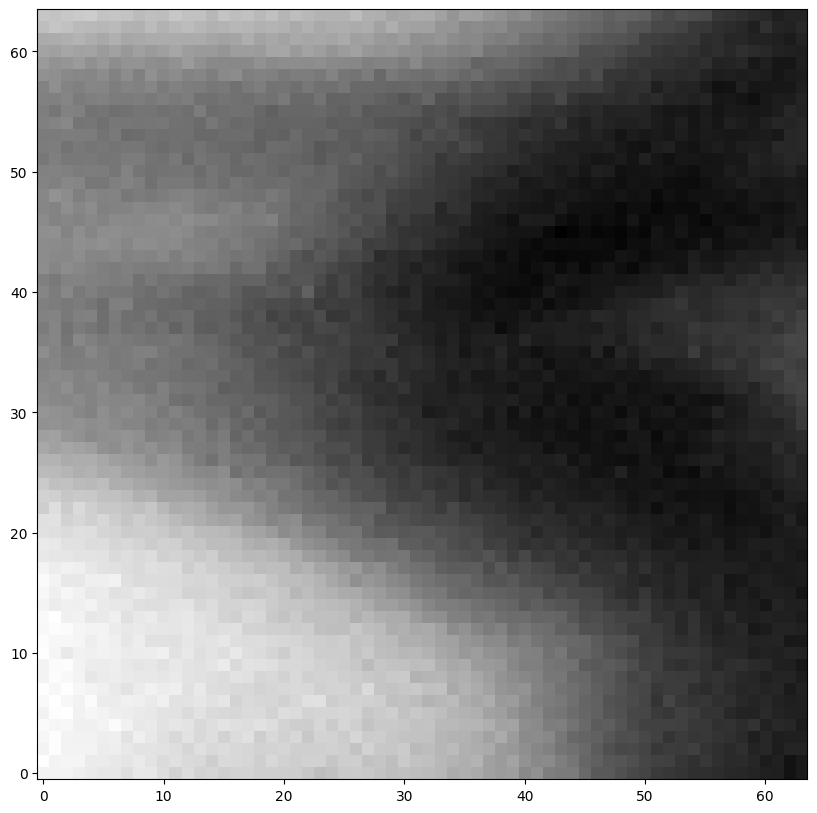

In [11]:
fig, axs = plt.subplots(1, 1, figsize=(20, 10))
axs.imshow(fits_array[1000:1064, 1000:1064, 0], cmap='gray', origin='lower')
plt.show()

In [41]:
from tqdm import tqdm

cutoffs = [0.1]
lowpass_img = [get_filtered(fits_array_cont[:, :, i], cutoffs) for i in tqdm(range(3))]

100%|██████████| 3/3 [00:02<00:00,  1.18it/s]


In [42]:
lowpass_img[0][0].shape

(2160, 2560)

In [43]:
lowpass_img_stack = np.stack(lowpass_img, -1)

In [44]:
lowpass_img_stack = lowpass_img_stack[0]

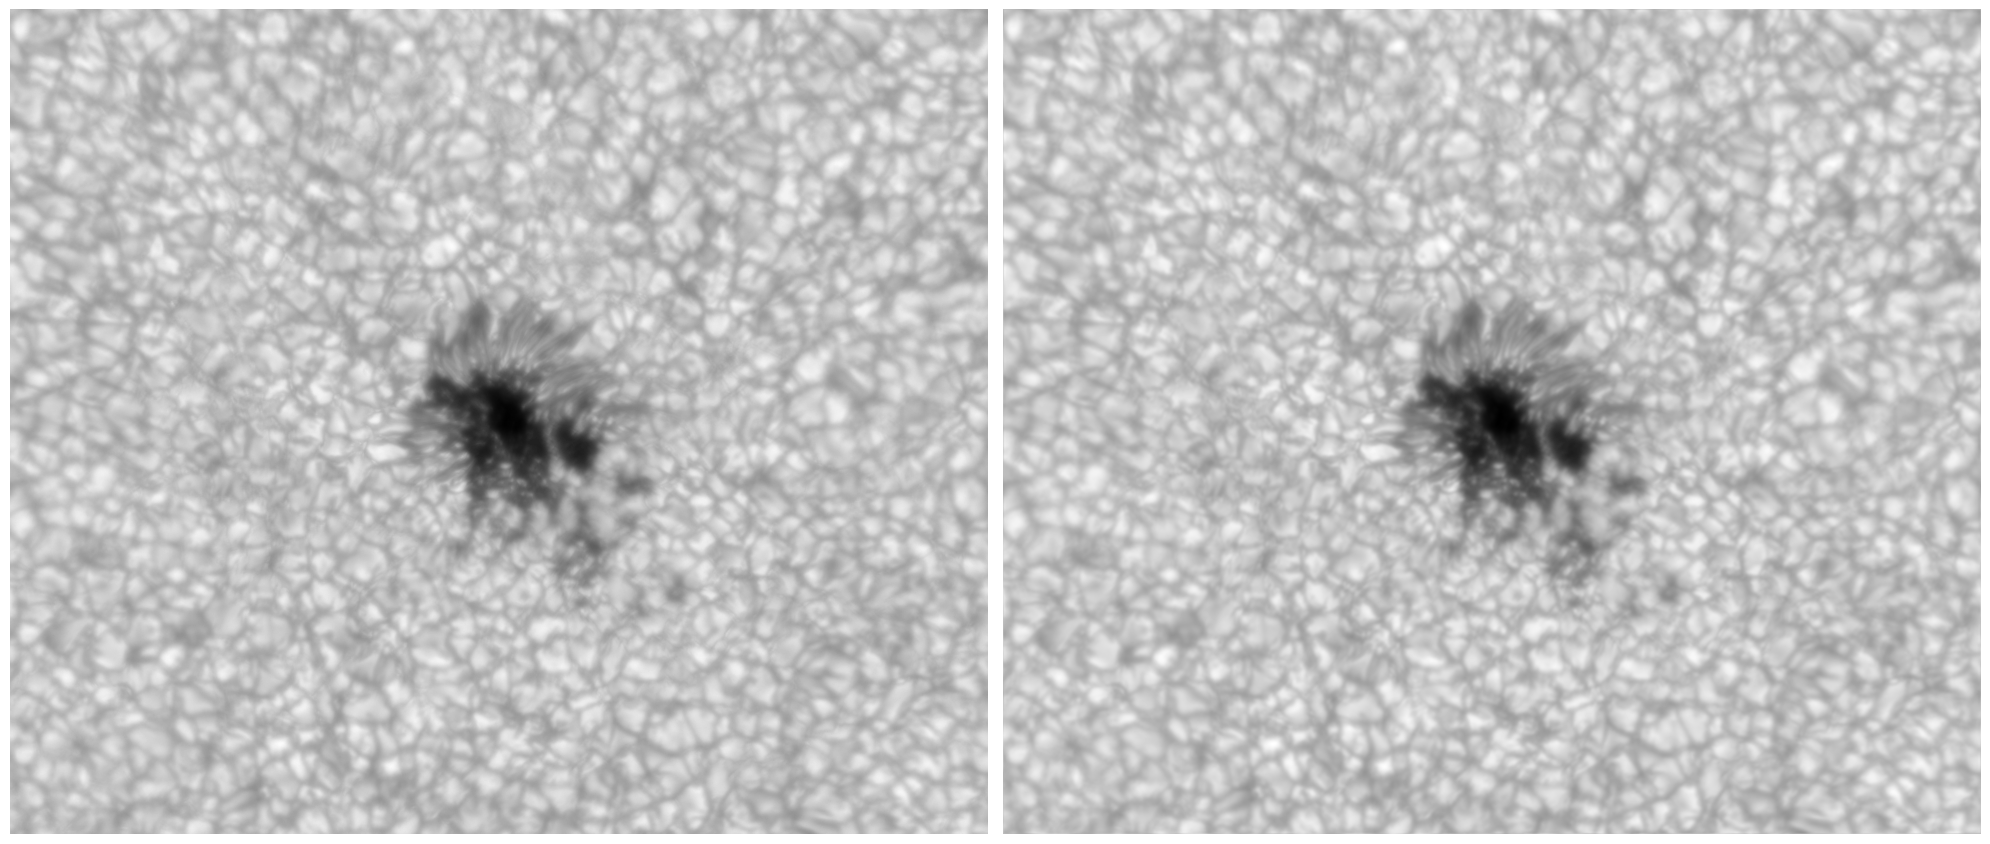

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(fits_array_cont[:, :, 0], cmap='gray', origin='lower')
axs[1].imshow(lowpass_img_stack[:, :, 0], cmap='gray', origin='lower')
#axs[1].imshow(highpass_img[0], cmap='gray', origin='lower')
[ax.axis('off') for ax in axs]
plt.tight_layout()
plt.show()

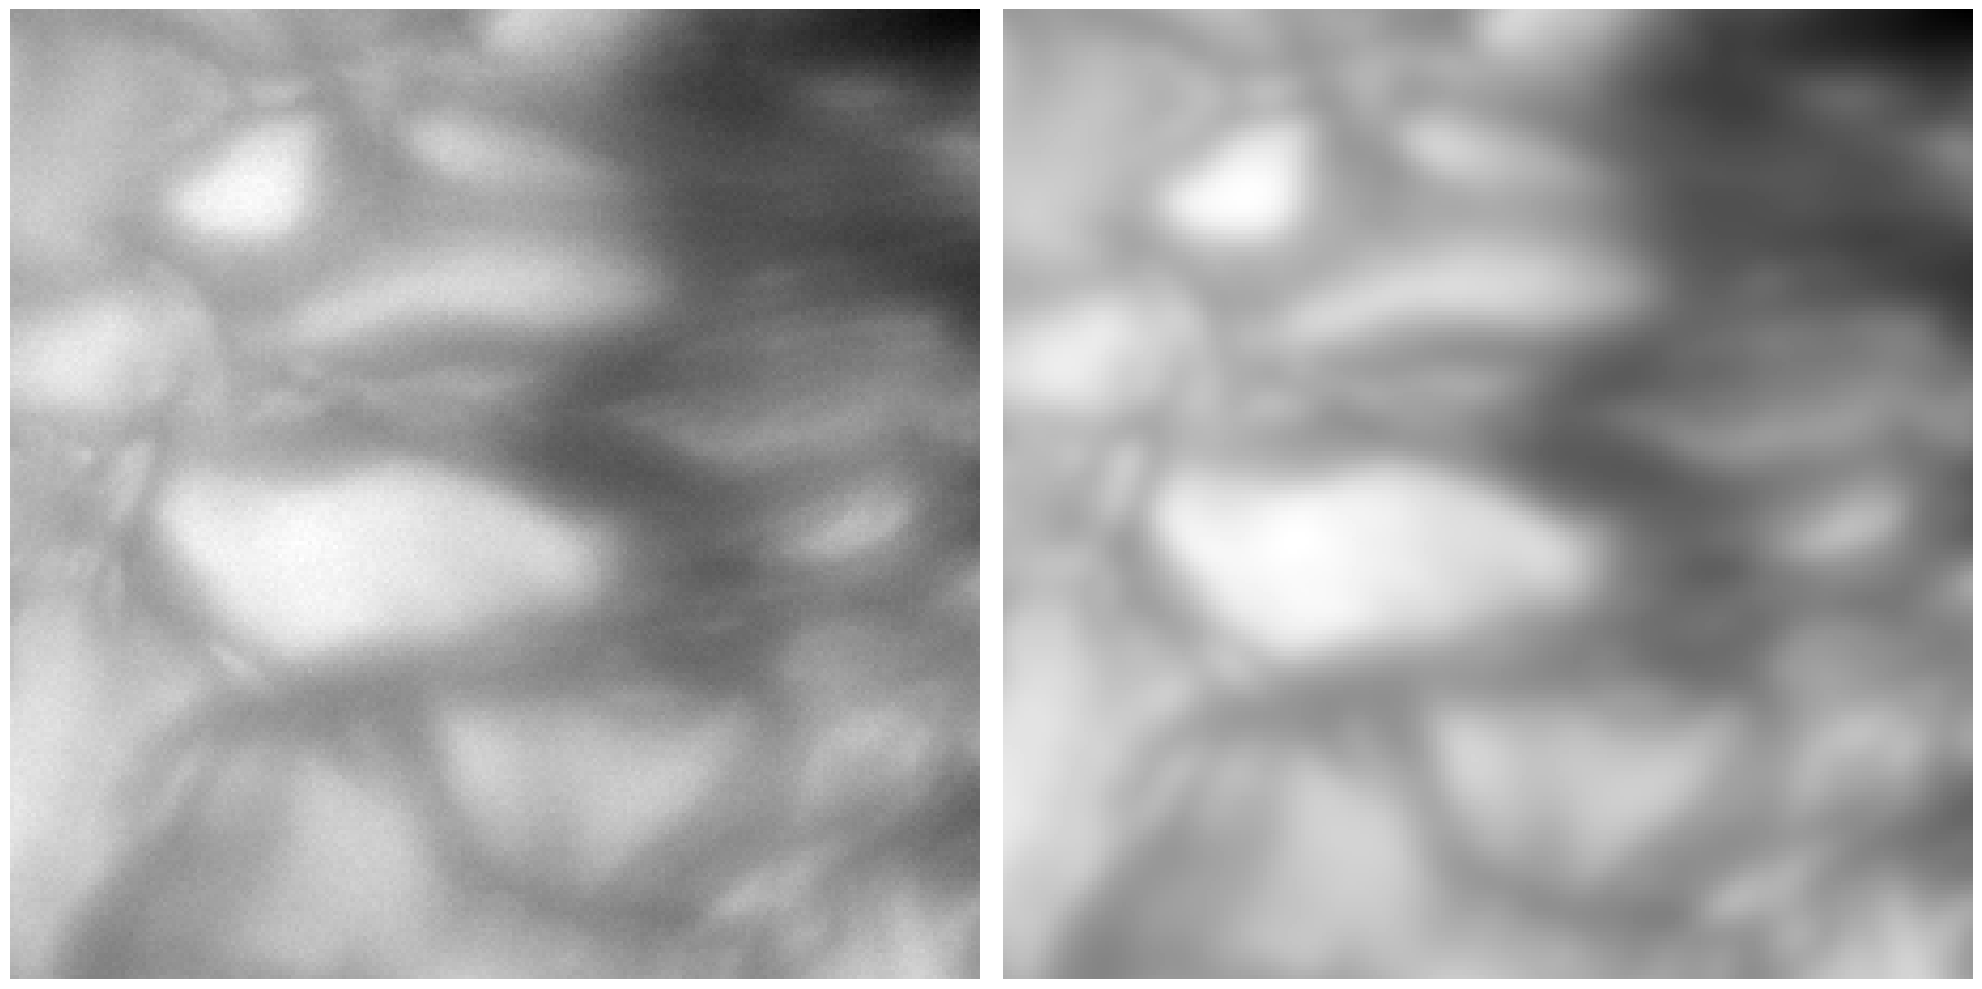

In [46]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(fits_array_cont[900:1128, 900:1128, 0], cmap='gray', origin='lower')
axs[1].imshow(lowpass_img_stack[900:1128, 900:1128, 0], cmap='gray', origin='lower')
#axs[1].imshow(highpass_img[0][900:1128, 900:1128], cmap='gray', origin='lower')
[ax.axis('off') for ax in axs]
plt.tight_layout()
plt.show()

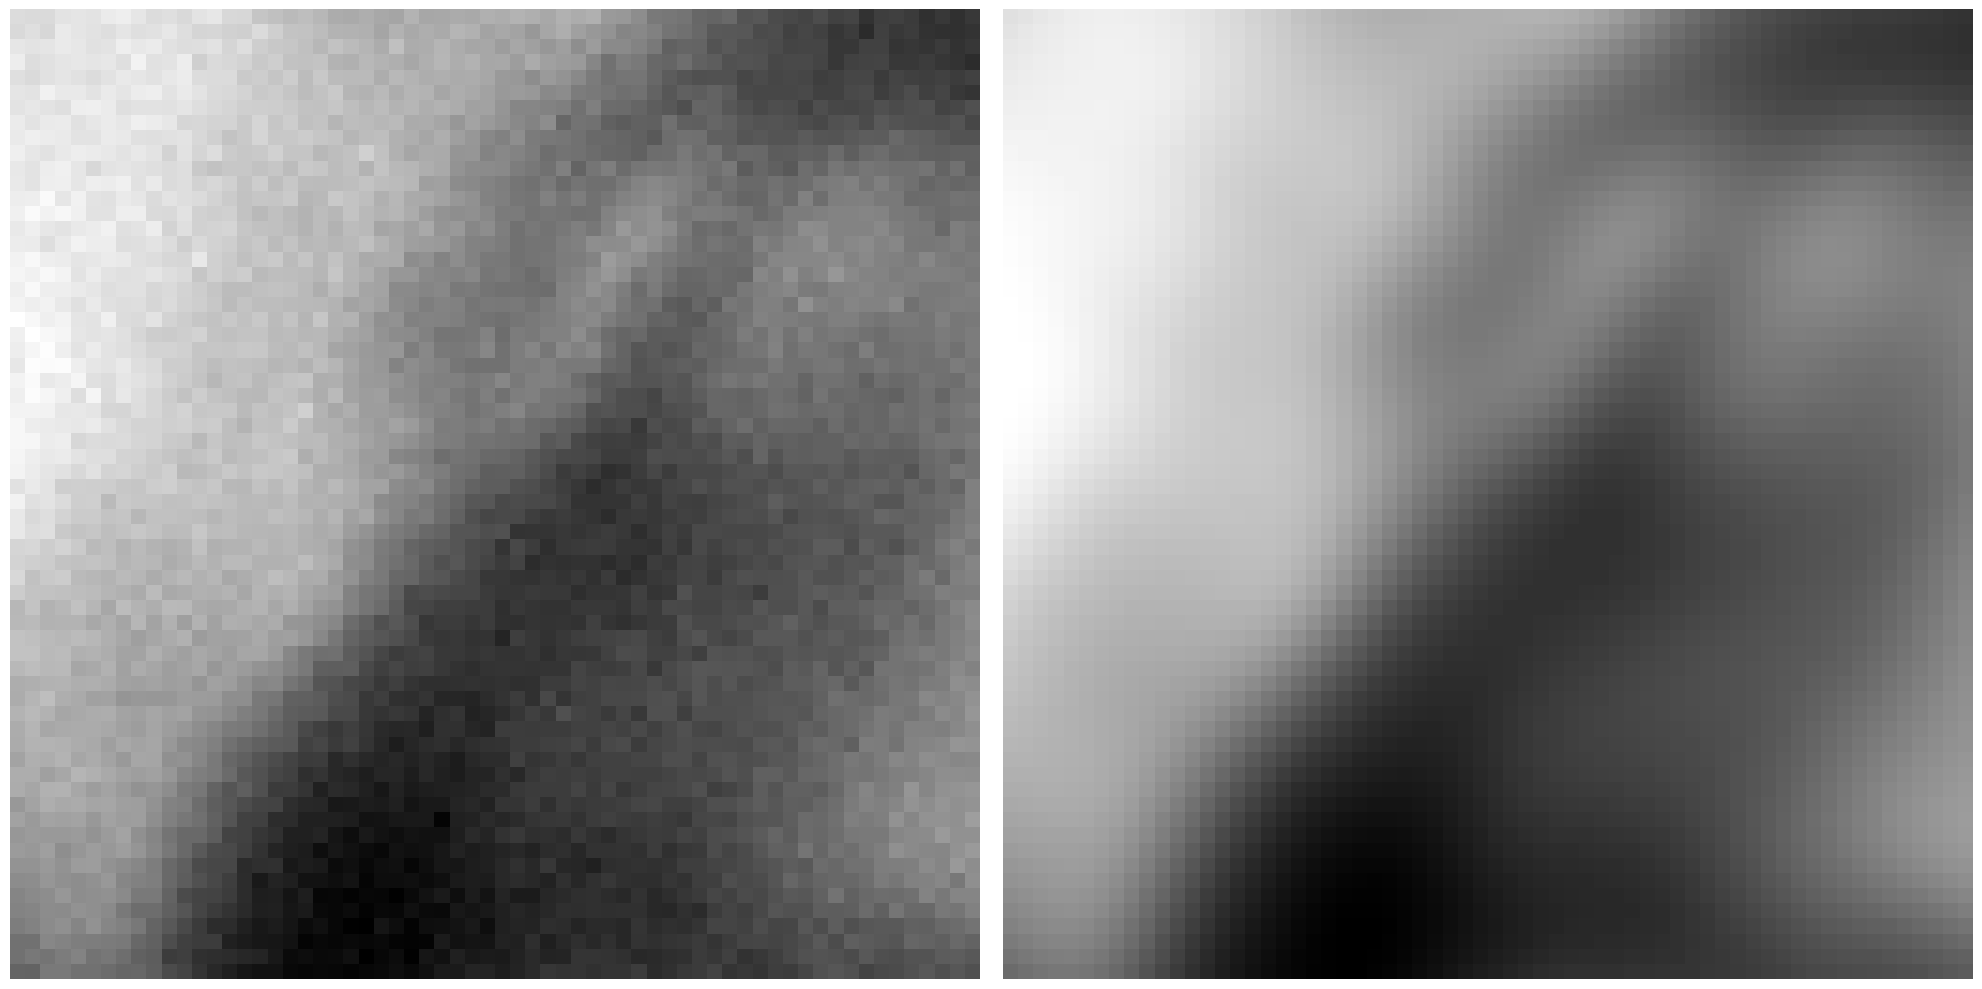

In [47]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
#axs[0].imshow(fits_array_cont[900:1128, 900:1128, 0], cmap='gray', origin='lower')
#axs[1].imshow(lowpass_img[0][900:1128, 900:1128], cmap='gray', origin='lower')
axs[0].imshow(fits_array_cont[900:964, 900:964, 0], cmap='gray', origin='lower')
axs[1].imshow(lowpass_img_stack[900:964, 900:964, 0], cmap='gray', origin='lower')
#axs[1].imshow(highpass_img[0][900:1128, 900:1128], cmap='gray', origin='lower')
[ax.axis('off') for ax in axs]
plt.tight_layout()
plt.show()

In [12]:
fits_array_cont_cut = fits_array_cont[100:228, 100:228, :]
print(fits_array_cont_cut.shape)

(128, 128, 80)


In [14]:
smoothed = [hpf(fits_array_cont_cut[:, :, i], 3) for i in range(5)]

In [23]:
smoothed[0][1].max()

0.20417995557165805

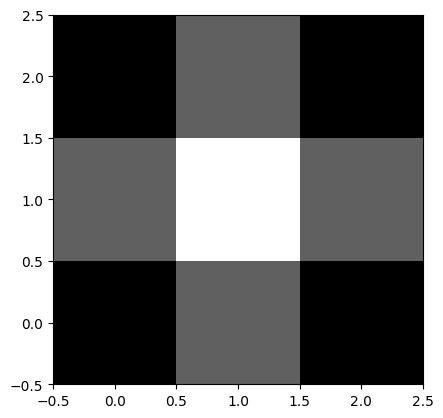

In [21]:
plt.imshow(smoothed[0][1], cmap='gray', origin='lower')
plt.show()

In [25]:
fits_array_cont_cut.min(), fits_array_cont_cut.max()

(0.8043505, 1.1920382)

In [27]:
smoothed[0][0].min(), smoothed[0][0].max()

(0.0, 1.1508667)

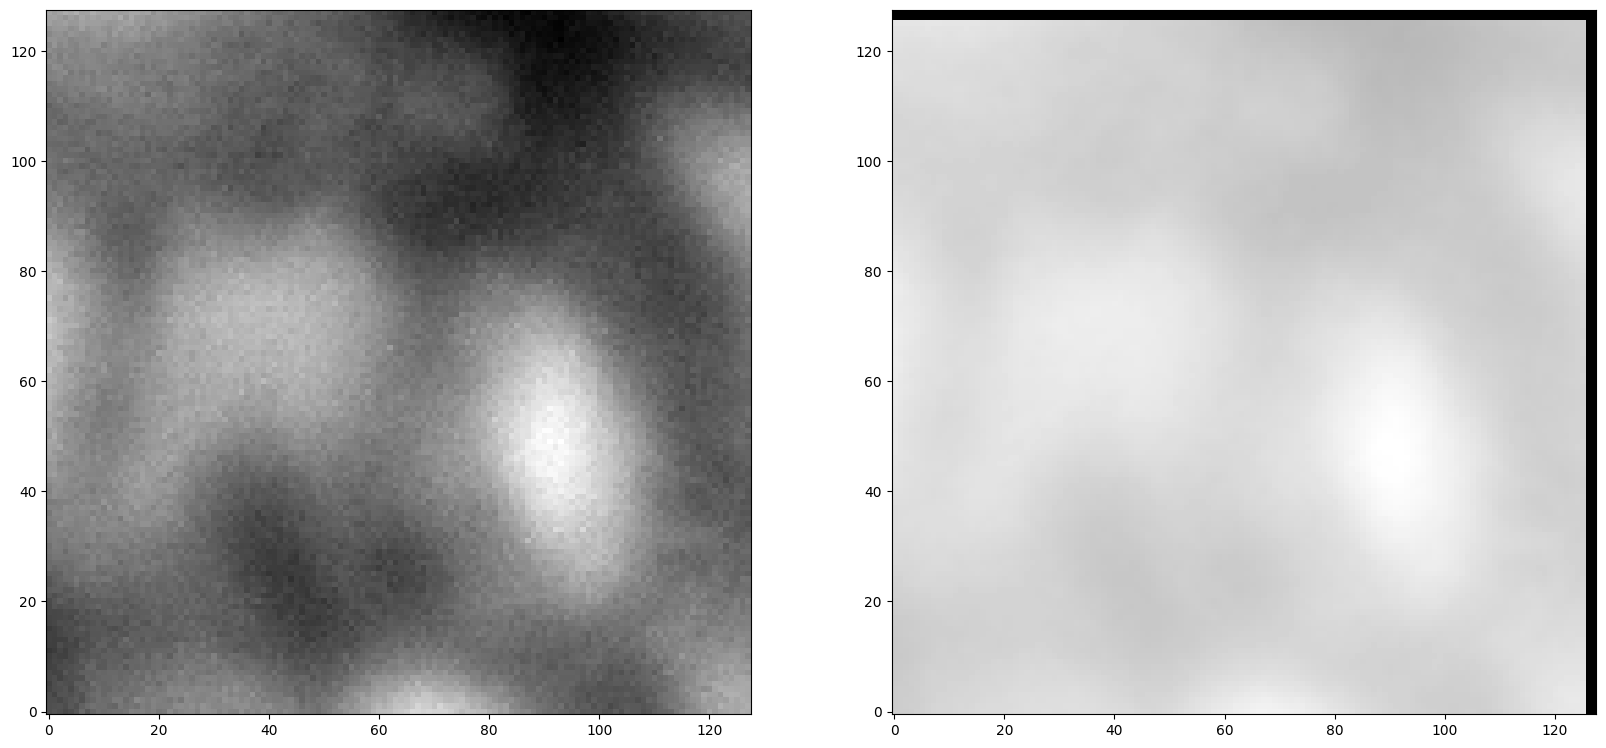

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(fits_array_cont_cut[:, :, 0], cmap='gray', origin='lower')
axs[1].imshow(smoothed[0][0], cmap='gray', origin='lower')
plt.show()

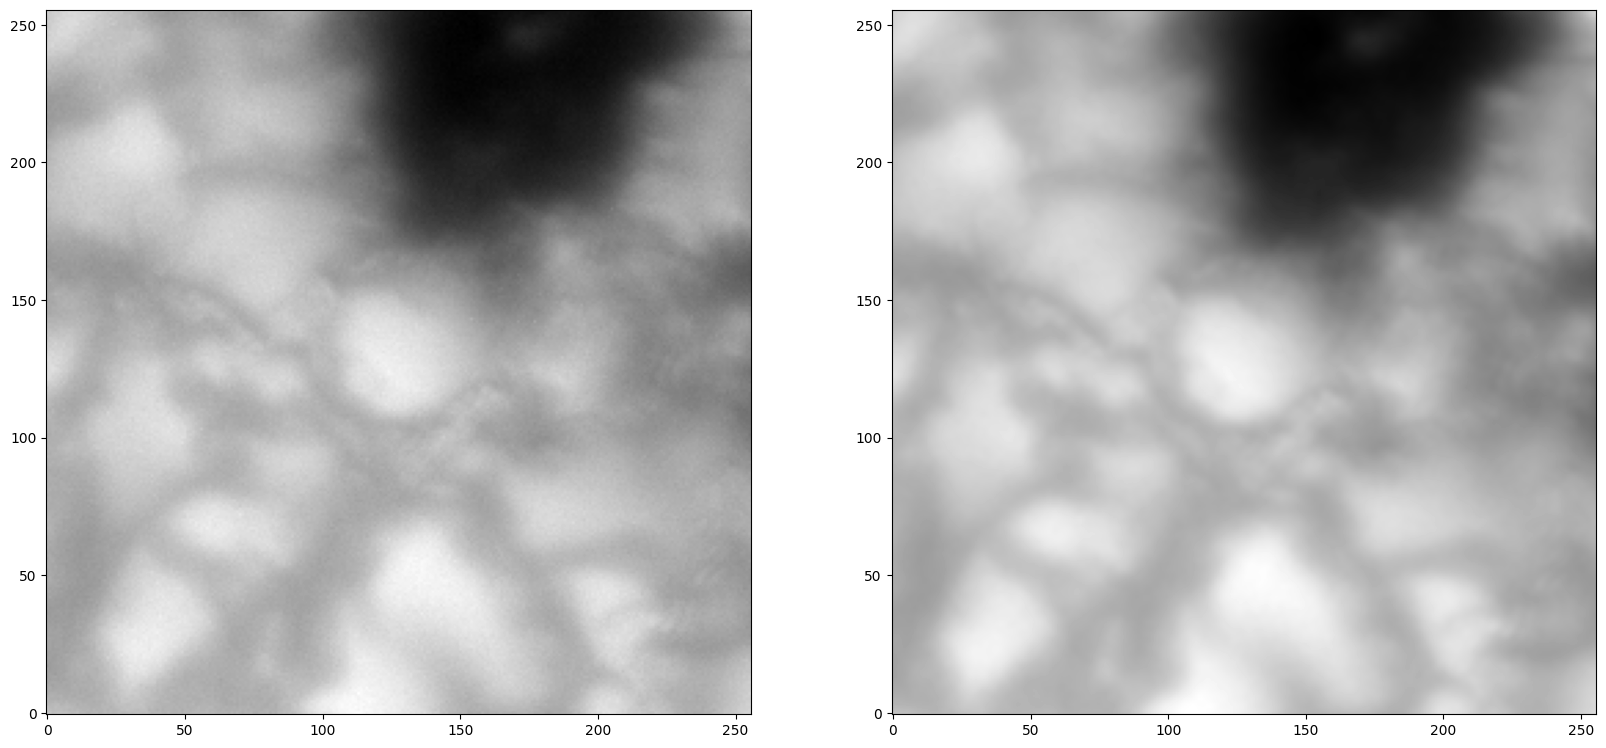

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(20, 10))
axs[0].imshow(fits_array[900:1156, 900:1156, 0], cmap='gray', origin='lower')
axs[1].imshow(smoothed[0][900:1156, 900:1156], cmap='gray', origin='lower')
plt.show()

In [6]:
shifts = [align_images(fits_array[:, :, 0], fits_array[:, :, i], 50) for i in range(1, 50)]

In [8]:
shifts[0][0][1]

-2

In [9]:
shifted_images = [np.roll(np.roll(fits_array[:, :, i], shifts[i][0][0], axis=0), shifts[i][0][1], axis=1) for i, shift
                  in enumerate(shifts)]

In [27]:
best_shift, max_corr = align_images(fits_array[:, :, 0], fits_array[:, :, 10], 10)

In [28]:
best_shift, max_corr

((-3, -1), 0.98660755)

In [30]:
shifted_image = np.roll(np.roll(fits_array[:, :, 10], best_shift[0], axis=0), best_shift[1], axis=1)

(128, 128)


In [33]:
fig, axs = plt.subplots(3, 1, figsize=(20, 10))
axs[0].imshow(fits_array[:, :, 0], cmap='gray', origin='lower')
axs[1].imshow(shifted_image, cmap='gray', origin='lower')
axs[2].imshow(fits_array[:, :, 10], cmap='gray', origin='lower')

In [17]:
shifts = []
for i in range(10):
    for j in range(10):
        shifts += [(i, j, correlation_coefficient(fits_array[:, :, 0], fits_array[:, :, 50]))]

In [18]:
shifts = np.array(shifts)

In [25]:
print(shifts)

[[0.         0.         0.96742207]
 [0.         1.         0.96742207]
 [0.         2.         0.96742207]
 [0.         3.         0.96742207]
 [0.         4.         0.96742207]
 [0.         5.         0.96742207]
 [0.         6.         0.96742207]
 [0.         7.         0.96742207]
 [0.         8.         0.96742207]
 [0.         9.         0.96742207]
 [1.         0.         0.96742207]
 [1.         1.         0.96742207]
 [1.         2.         0.96742207]
 [1.         3.         0.96742207]
 [1.         4.         0.96742207]
 [1.         5.         0.96742207]
 [1.         6.         0.96742207]
 [1.         7.         0.96742207]
 [1.         8.         0.96742207]
 [1.         9.         0.96742207]
 [2.         0.         0.96742207]
 [2.         1.         0.96742207]
 [2.         2.         0.96742207]
 [2.         3.         0.96742207]
 [2.         4.         0.96742207]
 [2.         5.         0.96742207]
 [2.         6.         0.96742207]
 [2.         7.         0.96

In [19]:
best_shift = shifts[np.argmax(shifts[:, 2])]

In [20]:
best_shift

array([0.        , 0.        , 0.98456997])

In [21]:
center = (fits_array[:, :, 0].shape[0] // 2 - fits_array[:, :, 50].shape[0] // 2,
          fits_array[:, :, 0].shape[1] // 2 - fits_array[:, :, 50].shape[1] // 2)

In [22]:
center

(0, 0)

In [23]:
center[0] - best_shift[0], center[1] - best_shift[1]

(0.0, 0.0)